In [4]:
# libraries
import pandas as pd
import networkx as nx
from source.utils import train_val_test_labels, labels_to_numbers, load_data_df, describe_pyg_data
from source.structure_modeling import torch_geometric_data_from_graph
from source.models import GraphSAGE, GraphSAGE2, train_model,test
import matplotlib.pyplot as plt
# libraries


## Labels

In [5]:
audio_dir="audio/"
labels_train, labels_valid, labels_test = train_val_test_labels(audio_dir, "training_list.txt", "validation_list.txt", "testing_list.txt", index_col=None, header=None, pos=0)
labels = labels_train + labels_valid + labels_test
label_names, labels_nr = labels_to_numbers(labels)

In [6]:
spectr_dir = "spectrograms/"
spectr_labels_train, spectr_labels_valid, spectr_labels_test = train_val_test_labels(spectr_dir, "spectr_train_list.txt", "spectr_valid_list.txt", "spectr_test_list.txt", index_col=0, header=0, pos=1)
spectr_labels = spectr_labels_train + spectr_labels_valid + spectr_labels_test
spectr_label_names, spectr_labels_nr = labels_to_numbers(spectr_labels)

## Datasets

In [7]:
raw_audio_df = load_data_df("data/raw_audio/")
spectr2_df = load_data_df("data/spectrogram2/")
spectr3_df = load_data_df("data/spectrogram3/")

## Graphs

In [8]:
raw_audio_G = nx.read_adjlist("graphs/raw_audio_kNN.adjlist")
spectr2_G = nx.read_adjlist("graphs/spectr2_kNN.adjlist")
spectr3_G = nx.read_adjlist("graphs/spectr3_kNN.adjlist")

## Create torch_geometric.data

In [9]:
raw_audio_data = torch_geometric_data_from_graph(raw_audio_G, raw_audio_df, labels_nr, len(labels_train), len(labels_valid), len(labels_test))
describe_pyg_data(raw_audio_data)

Number of nodes: 23682
Number of edges: 185200
Number of features: 1600
Number of classes: 10
Average node degree: 7.82
Number of training nodes: 18538
Number of validation nodes: 2567
Number of testing nodes: 2577
Training node label rate: 0.78
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [10]:
spectr2_data = torch_geometric_data_from_graph(spectr2_G, spectr2_df, spectr_labels_nr, len(spectr_labels_train), len(spectr_labels_valid), len(spectr_labels_test))
describe_pyg_data(spectr2_data)

Number of nodes: 23682
Number of edges: 151290
Number of features: 64
Number of classes: 10
Average node degree: 6.39
Number of training nodes: 18538
Number of validation nodes: 2567
Number of testing nodes: 2577
Training node label rate: 0.78
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
spectr3_data = torch_geometric_data_from_graph(spectr3_G, spectr3_df, spectr_labels_nr, len(spectr_labels_train), len(spectr_labels_valid), len(spectr_labels_test))
describe_pyg_data(spectr3_data)

Number of nodes: 23682
Number of edges: 155866
Number of features: 256
Number of classes: 10
Average node degree: 6.58
Number of training nodes: 18538
Number of validation nodes: 2567
Number of testing nodes: 2577
Training node label rate: 0.78
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## GraphSAGE - best architecture search

## Experiments with early stopping

In [8]:
models = [GraphSAGE(spectr2_data, 16), GraphSAGE(spectr2_data, 64), GraphSAGE(spectr2_data, 256), GraphSAGE2(spectr2_data, 16,16), GraphSAGE2(spectr2_data, 64,64), GraphSAGE2(spectr2_data, 256, 256)]
epochs = 500
es_patience = 50
es_threshold = 0.0001

In [9]:
model_results = []
for i, model in enumerate(models):
    print(f"Model {model}")
    results = train_model(model, spectr2_data, epochs, es_patience, es_threshold)
    model_results.append(results)

Model GraphSAGE(
  (conv1): SAGEConv(64, 16, aggr=mean)
  (conv2): SAGEConv(16, 10, aggr=mean)
)
Epoch: 000, Train loss: 3.1041, Valid Acc: 0.1040
Epoch: 001, Train loss: 2.4681, Valid Acc: 0.1079
Epoch: 002, Train loss: 2.3229, Valid Acc: 0.1145
Epoch: 003, Train loss: 2.3022, Valid Acc: 0.1110
Epoch: 004, Train loss: 2.2943, Valid Acc: 0.1106
Epoch: 005, Train loss: 2.2886, Valid Acc: 0.1087
Epoch: 006, Train loss: 2.2778, Valid Acc: 0.1083
Epoch: 007, Train loss: 2.2712, Valid Acc: 0.1106
Epoch: 008, Train loss: 2.2664, Valid Acc: 0.1071
Epoch: 009, Train loss: 2.2563, Valid Acc: 0.1114
Epoch: 010, Train loss: 2.2481, Valid Acc: 0.1165
Epoch: 011, Train loss: 2.2447, Valid Acc: 0.1184
Epoch: 012, Train loss: 2.2355, Valid Acc: 0.1145
Epoch: 013, Train loss: 2.2242, Valid Acc: 0.1141
Epoch: 014, Train loss: 2.2157, Valid Acc: 0.1153
Epoch: 015, Train loss: 2.2116, Valid Acc: 0.1153
Epoch: 016, Train loss: 2.2000, Valid Acc: 0.1196
Epoch: 017, Train loss: 2.1910, Valid Acc: 0.1231
Epo

In [12]:
for i, model in enumerate(models):
    model_results[i].to_csv(f"metrics/best_arch_search_{model.conv2}.csv", index=None)
    print(f"Model {model} : test accuracy: {test(model, spectr2_data)}")
    

Model GraphSAGE(
  (conv1): SAGEConv(64, 16, aggr=mean)
  (conv2): SAGEConv(16, 10, aggr=mean)
) : test accuracy: 0.3077221575475359
Model GraphSAGE(
  (conv1): SAGEConv(64, 64, aggr=mean)
  (conv2): SAGEConv(64, 10, aggr=mean)
) : test accuracy: 0.3857198292588281
Model GraphSAGE(
  (conv1): SAGEConv(64, 256, aggr=mean)
  (conv2): SAGEConv(256, 10, aggr=mean)
) : test accuracy: 0.393092743500194
Model GraphSAGE2(
  (conv1): SAGEConv(64, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (conv3): SAGEConv(16, 10, aggr=mean)
) : test accuracy: 0.19014357780364766
Model GraphSAGE2(
  (conv1): SAGEConv(64, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 10, aggr=mean)
) : test accuracy: 0.336825766395033
Model GraphSAGE2(
  (conv1): SAGEConv(64, 256, aggr=mean)
  (conv2): SAGEConv(256, 256, aggr=mean)
  (conv3): SAGEConv(256, 10, aggr=mean)
) : test accuracy: 0.25572370974000774


Text(0.5, 1.0, 'Performance of different GraphSAGE architectures on spect2+kNN dataset')

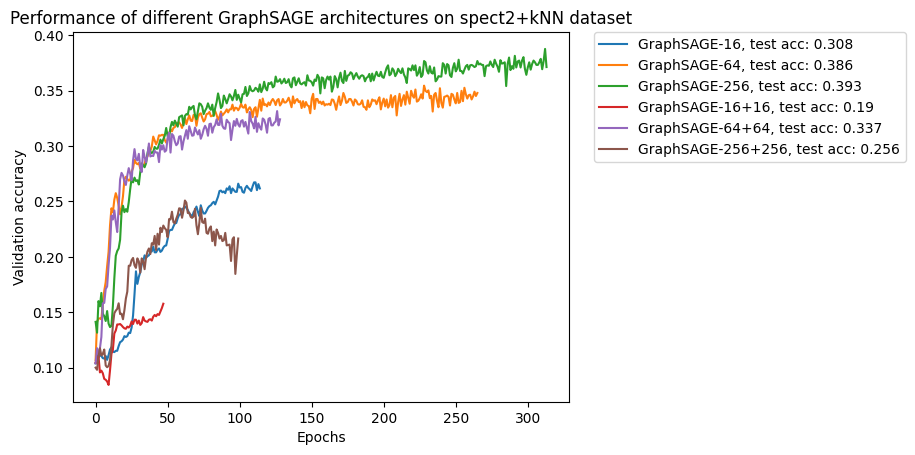

In [33]:
model_names = ["GraphSAGE-16", "GraphSAGE-64", "GraphSAGE-256", "GraphSAGE-16+16", "GraphSAGE-64+64", "GraphSAGE-256+256"]
for i, model in enumerate(models):
        model_scores = model_results[i]
        plt.plot(model_scores['epoch'], model_scores['valid_acc'], label=model_names[i]+f", test acc: {round(test(model, spectr2_data),3)}")
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Performance of different GraphSAGE architectures on spect2+kNN dataset")


In [12]:
models = [GraphSAGE(spectr3_data, 16), GraphSAGE(spectr3_data, 64), GraphSAGE(spectr3_data, 256), GraphSAGE2(spectr3_data, 16,16), GraphSAGE2(spectr3_data, 64,64), GraphSAGE2(spectr3_data, 256, 256)]
epochs = 500
es_patience = 50
es_threshold = 0.0001

In [13]:
model_results = []
for i, model in enumerate(models):
    print(f"Model {model}")
    results = train_model(model, spectr3_data, epochs, es_patience, es_threshold)
    model_results.append(results)

Model GraphSAGE(
  (conv1): SAGEConv(256, 16, aggr=mean)
  (conv2): SAGEConv(16, 10, aggr=mean)
)
Epoch: 000, Train loss: 4.4089, Valid Acc: 0.1149
Epoch: 001, Train loss: 2.3640, Valid Acc: 0.1134
Epoch: 002, Train loss: 2.3054, Valid Acc: 0.1180
Epoch: 003, Train loss: 2.3011, Valid Acc: 0.1274
Epoch: 004, Train loss: 2.2926, Valid Acc: 0.1426
Epoch: 005, Train loss: 2.2840, Valid Acc: 0.1422
Epoch: 006, Train loss: 2.2886, Valid Acc: 0.1469
Epoch: 007, Train loss: 2.2739, Valid Acc: 0.1449
Epoch: 008, Train loss: 2.2676, Valid Acc: 0.1434
Epoch: 009, Train loss: 2.2588, Valid Acc: 0.1441
Epoch: 010, Train loss: 2.2544, Valid Acc: 0.1391
Epoch: 011, Train loss: 2.2471, Valid Acc: 0.1422
Epoch: 012, Train loss: 2.2448, Valid Acc: 0.1441
Epoch: 013, Train loss: 2.2341, Valid Acc: 0.1410
Epoch: 014, Train loss: 2.2266, Valid Acc: 0.1391
Epoch: 015, Train loss: 2.2193, Valid Acc: 0.1426
Epoch: 016, Train loss: 2.2111, Valid Acc: 0.1379
Epoch: 017, Train loss: 2.2064, Valid Acc: 0.1414
Ep

Text(0.5, 1.0, 'Performance of different GraphSAGE architectures on spect3+kNN dataset')

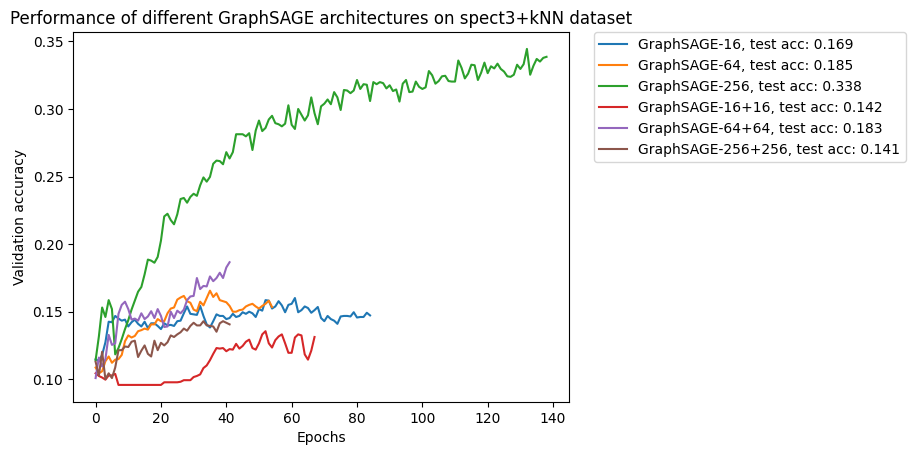

In [16]:
model_names = ["GraphSAGE-16", "GraphSAGE-64", "GraphSAGE-256", "GraphSAGE-16+16", "GraphSAGE-64+64", "GraphSAGE-256+256"]
for i, model in enumerate(models):
        model_scores = model_results[i]
        plt.plot(model_scores['epoch'], model_scores['valid_acc'], label=model_names[i]+f", test acc: {round(test(model, spectr3_data),3)}")
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Performance of different GraphSAGE architectures on spect3+kNN dataset")